In [1]:
from itertools import islice
import json
import pickle

import matplotlib.pylab as pl
%matplotlib inline
import numpy as np
from sklearn.metrics import confusion_matrix

In [2]:
input_dir = '/work/yu_gai/cfq'

In [3]:
idx2tok, _ = pickle.load(open(f'{input_dir}/vocab.pickle', 'rb'))
idx2rel, _ = pickle.load(open(f'{input_dir}/rel-vocab.pickle', 'rb'))

In [43]:
desc = 'test'
global_step = 1

In [26]:
split = 'mcd1'
d = np.load(f'{input_dir}/splits/{split}.npz')
idx = d[f'{desc}Idxs']

In [44]:
d = np.load(f'{input_dir}/{desc}-{global_step}.npz')
m, src, dst, rel_true, rel_pred, cfq_idx = d['m'], d['src'], d['dst'], d['rel_true'], d['rel_pred'], d['cfq_idx']

In [23]:
df = sqlCtx.read.parquet(f'/data/yu_gai/cfq/dataset.parquet/')

In [18]:
question = df.rdd.map(lambda r: r['questionPatternModEntities']).collect()

In [9]:
sparql = df.rdd.map(lambda r: r['sparqlPatternModEntities']).collect()

In [35]:
class bcolors:
    HEADER = '\033[95m'
    OKBLUE = '\033[94m'
    OKGREEN = '\033[92m'
    WARNING = '\033[93m'
    FAIL = '\033[91m'
    ENDC = '\033[0m'
    BOLD = '\033[1m'
    UNDERLINE = '\033[4m'

In [49]:
indptr = np.cumsum(np.hstack([[0], m]))
for i, j, k in islice(zip(cfq_idx, indptr[:-1], indptr[1:]), 5):
    print(question[i])
    print(sparql[i])

    for src_, dst_, rel_true_, rel_pred_ in zip(src[j : k], dst[j : k], rel_true[j : k], rel_pred[j : k]):
        prefix = bcolors.ENDC if rel_true_ == rel_pred_ else bcolors.FAIL
        postfix = '' if rel_true_ == rel_pred_ else ' ' + idx2rel[rel_true_]
        print(f'{prefix}{idx2tok[src_]} {idx2rel[rel_pred_]} {idx2tok[dst_]}{bcolors.ENDC}{postfix}')

    print()

Were M1 and M3 produced by M0 's cinematographer , writer , art director , and executive producer and directed by M2
SELECT count(*) WHERE {
?x0 ns:film.cinematographer.film M0 .
?x0 ns:film.film_art_director.films_art_directed M0 .
?x0 ns:film.producer.films_executive_produced M0 .
?x0 ns:film.writer.film M0 .
M1 ns:film.film.directed_by M2 .
M1 ns:film.film.produced_by|ns:film.film.production_companies ?x0 .
M3 ns:film.film.directed_by M2 .
M3 ns:film.film.produced_by|ns:film.film.production_companies ?x0
}
?x0 ns:film.writer.film M0 ns:film.cinematographer.film
?x0 ns:film.writer.film M0 ns:film.film_art_director.films_art_directed
?x0 ns:film.writer.film M0 ns:film.producer.films_executive_produced
?x0 ns:film.writer.film M0
M1 ns:film.film.directed_by M2
M1 ns:film.film.produced_by|ns:film.film.production_companies ?x0
M3 ns:film.film.directed_by M2
M3 ns:film.film.produced_by|ns:film.film.production_companies ?x0

Were M1 and M2 executive produced by M0 's writer , producer , art

In [53]:
for src, dst, rel_true, rel_pred in islice(zip(d['src'], d['dst'], d['rel_true'], d['rel_pred']), 100):
    if rel_true != rel_pred:
        print(idx2tok[src], idx2rel[rel_true], idx2tok[dst])
        print(idx2tok[src], idx2rel[rel_pred], idx2tok[dst])
        print()

?x0 ns:film.cinematographer.film M0
?x0 ns:film.writer.film M0

?x0 ns:film.film_art_director.films_art_directed M0
?x0 ns:film.writer.film M0

?x0 ns:film.producer.films_executive_produced M0
?x0 ns:film.writer.film M0

M1 ns:film.film.directed_by M2
M1 ns:film.film_art_director.films_art_directed M2

M1 ns:film.film.produced_by|ns:film.film.production_companies ?x0
M1 ns:film.film.directed_by ?x0

M3 ns:film.film.directed_by M2
M3 ns:film.director.film M2

?x0 ns:film.director.film M0
?x0 ns:film.writer.film M0

?x0 ns:film.film_art_director.films_art_directed M0
?x0 ns:film.writer.film M0

?x0 ns:film.producer.film|ns:film.production_company.films M0
?x0 ns:film.writer.film M0

M1 ns:film.film.executive_produced_by ?x0
M1 ns:film.film.produced_by|ns:film.film.production_companies ?x0

M2 ns:film.film.executive_produced_by ?x0
M2 ns:film.film.produced_by|ns:film.film.production_companies ?x0

?x0 ns:film.cinematographer.film M0
?x0 ns:film.actor.film/ns:film.performance.film M0

?x0 

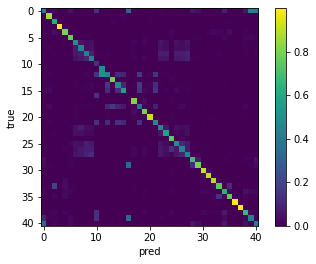

In [72]:
cm = confusion_matrix(rel_true, rel_pred, normalize='pred')
pl.imshow(cm)
pl.xlabel('pred')
pl.ylabel('true')
pl.colorbar()

Text(0, 0.5, 'tpr')

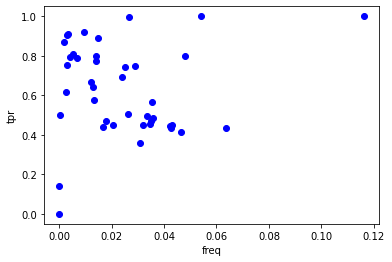

In [67]:
u, c = np.unique(rel_true, return_counts=True)
pl.plot(c / c.sum(), np.diag(cm), 'bo')
pl.xlabel('freq')
pl.ylabel('tpr')

In [71]:
diag = np.diag(cm)
list(zip(np.sort(diag), (idx2rel[idx] for idx in np.argsort(diag))))

[(0.0, 'ns:film.film.film_art_direction_by'),
 (0.14285714285714285, 'ns:film.film.cinematography'),
 (0.35660928873010717,
  'ns:film.film.produced_by|ns:film.film.production_companies'),
 (0.4159829838954725,
  'ns:people.person.spouse_s/ns:people.marriage.spouse|ns:fictional_universe.fictional_character.married_to/ns:fictional_universe.marriage_of_fictional_characters.spouses'),
 (0.4327760772309866, '!='),
 (0.43363086668586237, 'ns:film.director.film'),
 (0.4373239436619718,
  'ns:people.person.sibling_s/ns:people.sibling_relationship.sibling|ns:fictional_universe.fictional_character.siblings/ns:fictional_universe.sibling_relationship_of_fictional_characters.siblings'),
 (0.4458478903520559, 'ns:film.editor.film'),
 (0.44822485207100593, 'ns:film.writer.film'),
 (0.45097063215530114,
  'ns:film.producer.film|ns:film.production_company.films'),
 (0.45193798449612405, 'ns:film.cinematographer.film'),
 (0.45433893684688775, 'ns:film.film.directed_by'),
 (0.47023809523809523, 'ns:film